# Project Steps
**EDA**: Exploratory Analysis consists of understanding the nature of the data set, it serves to detect possible outliers.

**Fitur Engineering**: This is the most important step, because it is the part where we remove the annoying outliers and clean up the data. The quality of the algorithm depends on the cleanliness of the data, in short if you pass dirty data to your model your algorithm will be shit.

**Model Creation**: With a clean data set you can explore which algorithm offers the best performance, there are tools in Python that let you find the best combination of hyperparameters from the model.

**Model Development**: Once the model is finished, your job is to upload it to a server supported by a graphical interface to be able to generate new predictions..

## About Dataset
### Context
Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I know, Packt Publishing doesn't make its datasets available online unless you buy the book and create a user account which can be a problem if you check books from a library or borrow a book from a friend. All of these data sets are in the public domain but just need to be cleaned and recoded to fit the format in the book.

### Columns
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

### Goal
Can you accurately predict insurance costs?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


There is no data that is NaN, the average age is around 40 years, the minimum is 18 years and the maximum is 64 years. For the average number of children, they have 2 children and for charges it is around 13,270 US, but for a max value of about 63,700 US, which is very far from the average which indicates an outlier.
___
### EDA


<AxesSubplot:ylabel='region'>

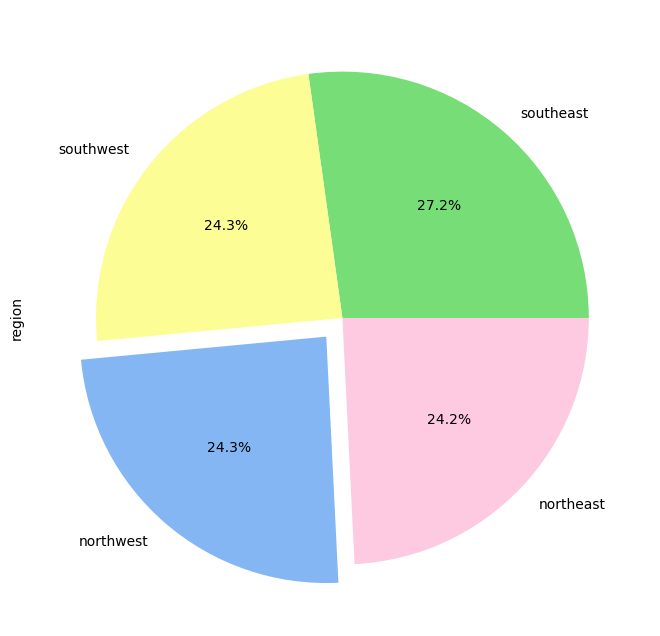

In [4]:
colors=['#77dd77','#fdfd96','#84b6f4','#fdcae1']
explode= [0,0,0.1,0]

df_region = df['region'].value_counts()
df_region.plot(kind='pie',
              figsize=(12,8),
              autopct='%1.1f%%',
              colors=colors,
              explode=explode)

#### Relationship categorical with target

<AxesSubplot:xlabel='smoker', ylabel='charges'>

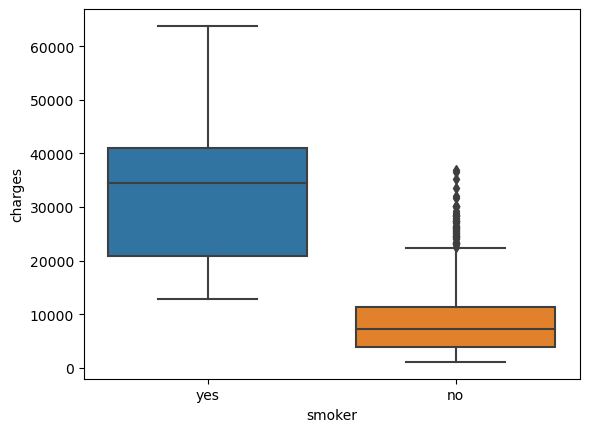

In [5]:
sns.boxplot(x='smoker', y='charges', data=df)

I found that smoking variable dramatically increases insurance prices, because most smokers have poor health compared to non-smokers

In [6]:
df.groupby("smoker")["charges"].mean()

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

The average price of smokers is much higher than that of non-smokers. Because smokers generally have worse health conditions and consequently higher medical costs.

<AxesSubplot:xlabel='bmi', ylabel='Count'>

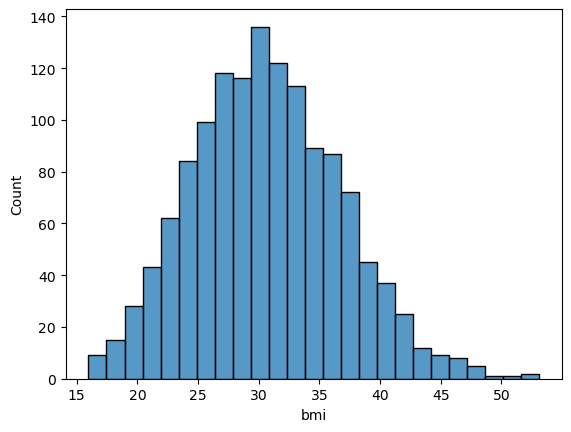

In [7]:
sns.histplot(x='bmi', data=df, bins=25)

On bmi also has some outliers. 

<AxesSubplot:xlabel='bmi', ylabel='charges'>

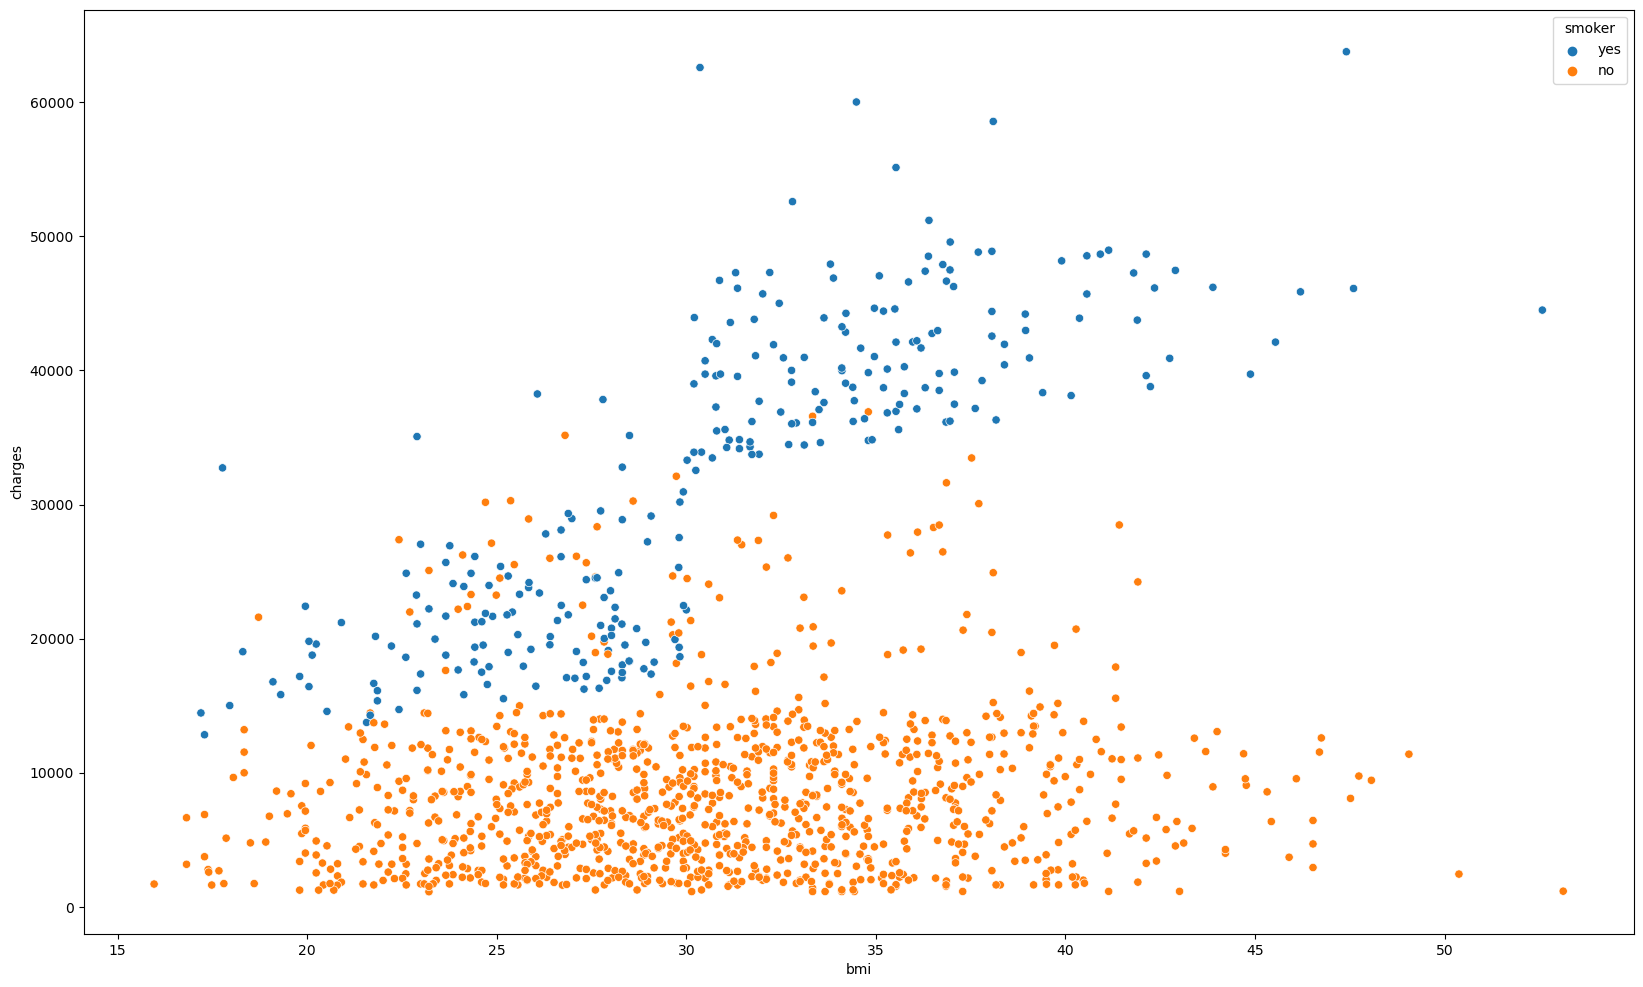

In [8]:
plt.figure(figsize=(20,12))
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

A person is obese if his BMI is equal to or above 30. When a person's BMI reaches 25–29.9, he is categorized as overweight. Normal BMI or ideal body weight is in the range of 18.5–24.9. In other words, the higher the BMI, the greater the insurance cost, especially if they are also smokers.

<AxesSubplot:xlabel='age', ylabel='charges'>

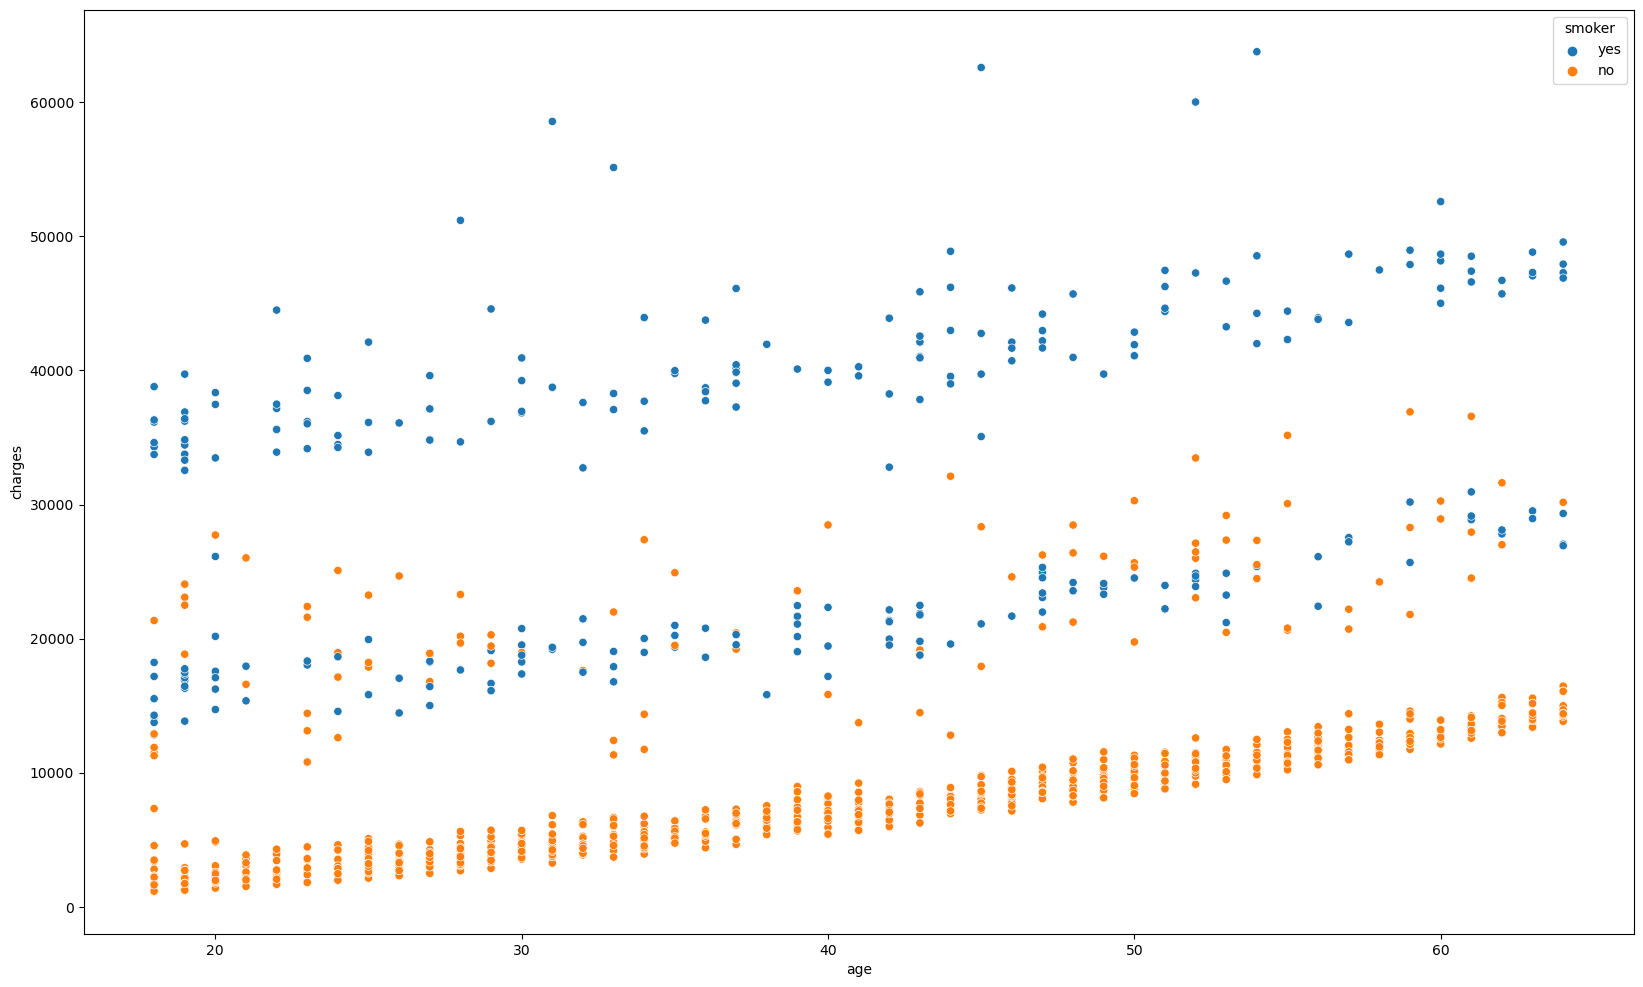

In [9]:
plt.figure(figsize=(20,12))
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')

The graphs represent 4 types of clusters:

- Smokers who have an adverse lifestyle as a consequence of their health insurance costs will be much higher.
- Smokers who smoke who may not smoke often and may have a healthy lifestyle, cost much less than their partners because they have a better quality of health.
- Non-smoker but with medical problems.
- Non-smokers who have a healthy quality of life, the price of health insurance will be much lower because medical problems will be much lower.

## Skewness dan Kurtosis
Skewness shows the slope of the data and Kurt shows the sharpness of the data

In [10]:
df['charges'].skew(), df['charges'].kurt()

(1.5158796580240388, 1.6062986532967907)

<AxesSubplot:xlabel='charges', ylabel='Count'>

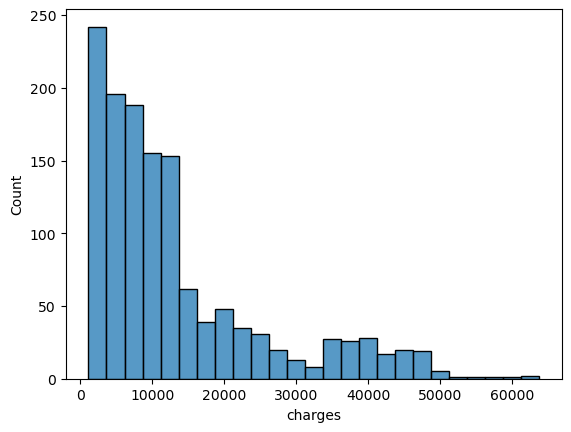

In [11]:
sns.histplot(x='charges', data=df, bins=25)

From the plot above, we can see that there are outliers that are very far from the average and this greatly disturbs the distribution of the data. We will change it with feature engineering

In [12]:
df[df['charges'] > 50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


### Benchmark Model

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [14]:
X = df.drop(columns='charges')
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
X_train.shape, X_test.shape

((1003, 6), (335, 6))

In [15]:
X_train.head()

,age,sex,bmi,children,smoker,region
1091,55,female,29.830,0,no,northeast
367,42,female,24.985,2,no,northwest
300,36,male,27.550,3,no,northeast
647,40,female,23.370,3,no,northeast
1257,54,female,27.645,1,no,northwest


In [16]:
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import grid_search_params as gsp

from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_residual, plot_actual_vs_prediction, plot_roc_curve

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='normalize'), ['age','bmi']),
    ('categoric', cat_pipe(encoder='onehot'), ['sex','children','smoker','region'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('MAE',mean_absolute_error(y_test,y_pred))
print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
MAE 4134.308632689776
{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.7511434214314779 0.741857691010638 0.7532881888143064


# Feature Engineering
#### Interval
Interval data does not have a defined absolute zero that is present in ratio data. The lack of an absolute zero point makes direct comparisons of quantities impossible. For example, Object A twice as large as Object B is not a possibility in the interval data. Source [here](https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097) and [Youtube](https://youtu.be/A3gClkblXK8)

Create a class to calculate the lower and upper intervals for each continuous variable.

In [18]:
class Intervals():
    
    def __init__(self,feature):
        self.mean = feature.mean()
        self.sd = feature.std()
        self.interval_range = [1.5,2,2.5,3,3.5,4]
    
    def Upper_Interval(self):
        for interval in self.interval_range:
            upper_interval = self.mean + interval * self.sd
            upper_interval = np.round(upper_interval, 2)
            print(f'Interval range {interval}: {upper_interval}')
            
    def Lower_Interval(self):
        for interval in self.interval_range:
            lower_interval = self.mean - interval * self.sd
            lower_interval = np.round(lower_interval, 2)
            print(f'Interval range {interval}: {lower_interval}')
            
class Best_Interval(Intervals):
    def __init__(self, feature):
        Intervals.__init__(self, feature)

#### BMI

In [19]:
Best_Interval(df.bmi).Upper_Interval()

Interval range 1.5: 39.81
Interval range 2: 42.86
Interval range 2.5: 45.91
Interval range 3: 48.96
Interval range 3.5: 52.01
Interval range 4: 55.06


I will take interval 3 as reference, all values higher than that interval will be replaced with the same value, since the dataset has less data, it would be disastrous to omit relevant information.

In [20]:
df.bmi = np.where(df.bmi > 48.96,48.96, df.bmi)
df[['bmi']]

,bmi
0,27.900
1,33.770
2,33.000
3,22.705
4,28.880
...,...
1333,30.970
1334,31.920
1335,36.850
1336,25.800


The class calculates the upper interval and we replace the abnormal value or data that is in a more normal range, in this case, because it is the upper interval, choose to change it for a value close to this interval.

#### Charges
We will create a data frame that contains people who don't smoke and who smoke

In [21]:
smoker_no_split = df.query("smoker == 'no'")
smoker_yes_split = df.query("smoker == 'yes'")

In [22]:
Best_Interval(smoker_no_split.charges).Upper_Interval()

Interval range 1.5: 17424.94
Interval range 2: 20421.83
Interval range 2.5: 23418.72
Interval range 3: 26415.61
Interval range 3.5: 29412.5
Interval range 4: 32409.4


I'll use the first suggested upper range, as it's a good starting point for creating a new feature<br>
For those values greater than $17,000 US, it will classify them as severe medical problems

In [23]:
smoker_no_split['medical_problem'] = smoker_no_split["charges"].apply(lambda x: "severe" if x > 17000 else "light")

C:\Users\fahmi\AppData\Local\Temp\ipykernel_8004\2714417569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoker_no_split['medical_problem'] = smoker_no_split["charges"].apply(lambda x: "severe" if x > 17000 else "light")


In [24]:
smoker_no_split.head()

,age,sex,bmi,children,smoker,region,charges,medical_problem
1,18,male,33.770,1,no,southeast,1725.55230,light
2,28,male,33.000,3,no,southeast,4449.46200,light
3,33,male,22.705,0,no,northwest,21984.47061,severe
4,32,male,28.880,0,no,northwest,3866.85520,light
5,31,female,25.740,0,no,southeast,3756.62160,light


<AxesSubplot:xlabel='age', ylabel='charges'>

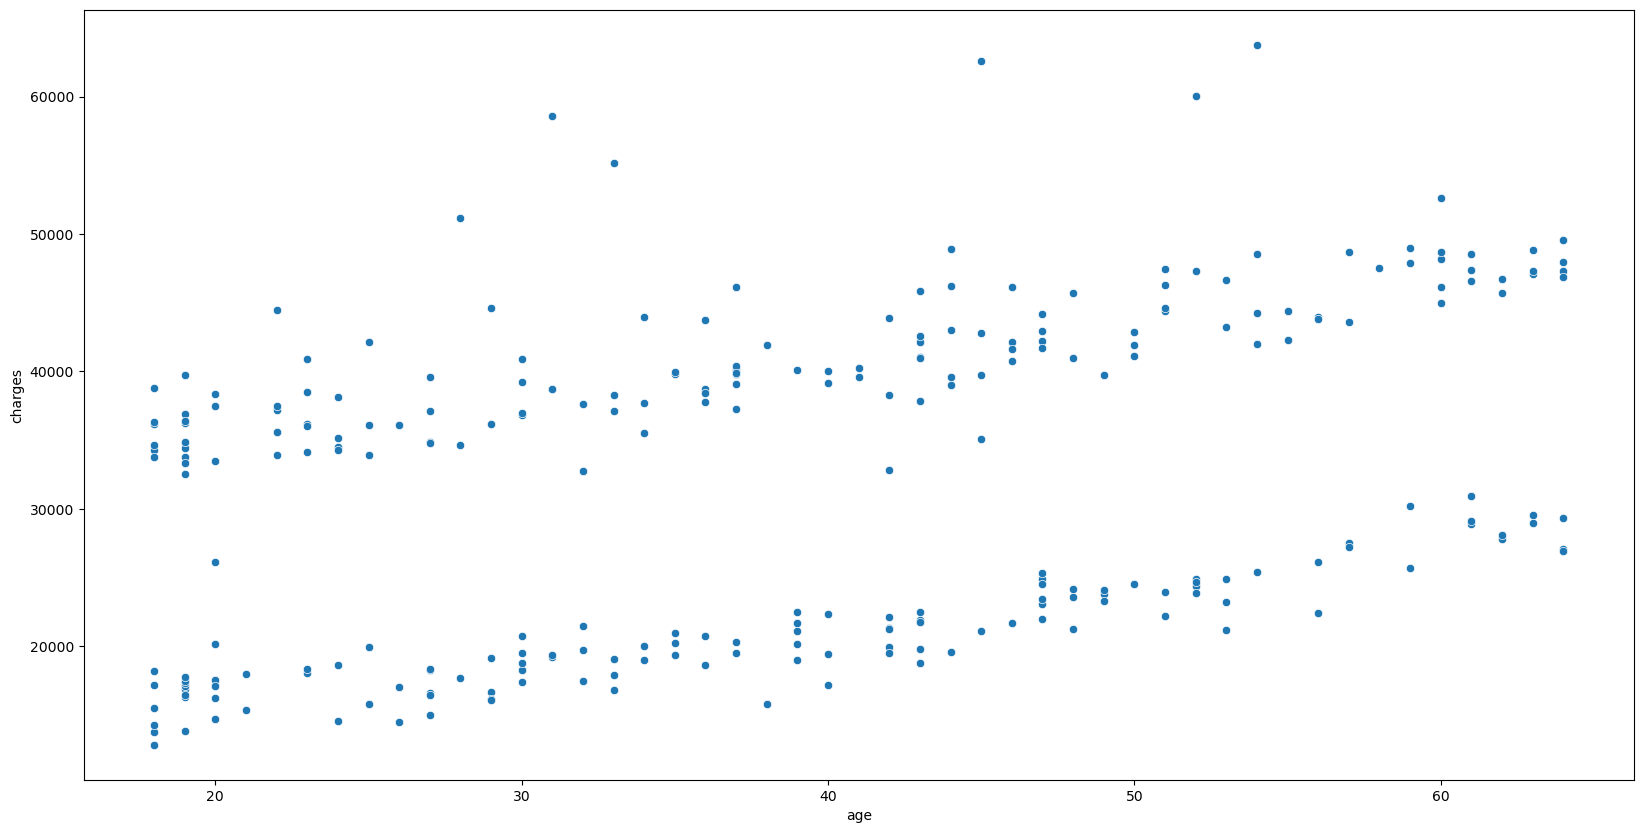

In [25]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='age', y='charges', data=smoker_yes_split)

In the case of smokers we can create a new group, in a similar way to non-smokers but with a different range, starting from insurance costs above 30K USD as in the plot above

In [26]:
smoker_yes_split['medical_problem'] = smoker_yes_split['charges'].apply(lambda x: "severe" if x > 30000 else "light")

C:\Users\fahmi\AppData\Local\Temp\ipykernel_8004\3624700627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoker_yes_split['medical_problem'] = smoker_yes_split['charges'].apply(lambda x: "severe" if x > 30000 else "light")


In [27]:
Best_Interval(smoker_yes_split.charges).Upper_Interval()

Interval range 1.5: 49362.55
Interval range 2: 55133.33
Interval range 2.5: 60904.1
Interval range 3: 66674.87
Interval range 3.5: 72445.65
Interval range 4: 78216.42


we changes outlier with interval 1

In [28]:
smoker_yes_split['charges'] = smoker_yes_split['charges'].apply(lambda x: 48000 if x > 48000 else x)

C:\Users\fahmi\AppData\Local\Temp\ipykernel_8004\2491287898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoker_yes_split['charges'] = smoker_yes_split['charges'].apply(lambda x: 48000 if x > 48000 else x)


Create dataframe

In [29]:
df_clear = pd.concat([smoker_no_split, smoker_yes_split])
df_clear.head()

,age,sex,bmi,children,smoker,region,charges,medical_problem
1,18,male,33.770,1,no,southeast,1725.55230,light
2,28,male,33.000,3,no,southeast,4449.46200,light
3,33,male,22.705,0,no,northwest,21984.47061,severe
4,32,male,28.880,0,no,northwest,3866.85520,light
5,31,female,25.740,0,no,southeast,3756.62160,light


In [30]:
def boxplot():
    

    fig,(ax_box_1,ax_box_2)=plt.subplots(1,2,figsize=(20,8))
    
    ax_box_1.set_title("Adding new feature")

    sns.boxplot(data=df_clear,x="smoker",
            y="charges",
            hue="medical_problem",
            palette="Set2",
            ax=ax_box_1)

    ax_box_2.set_title("Without the new feature")
    sns.boxplot(data=df,
            x="smoker",
            y="charges",
            palette="Set2",
            ax=ax_box_2)
    
    
    plt.show()

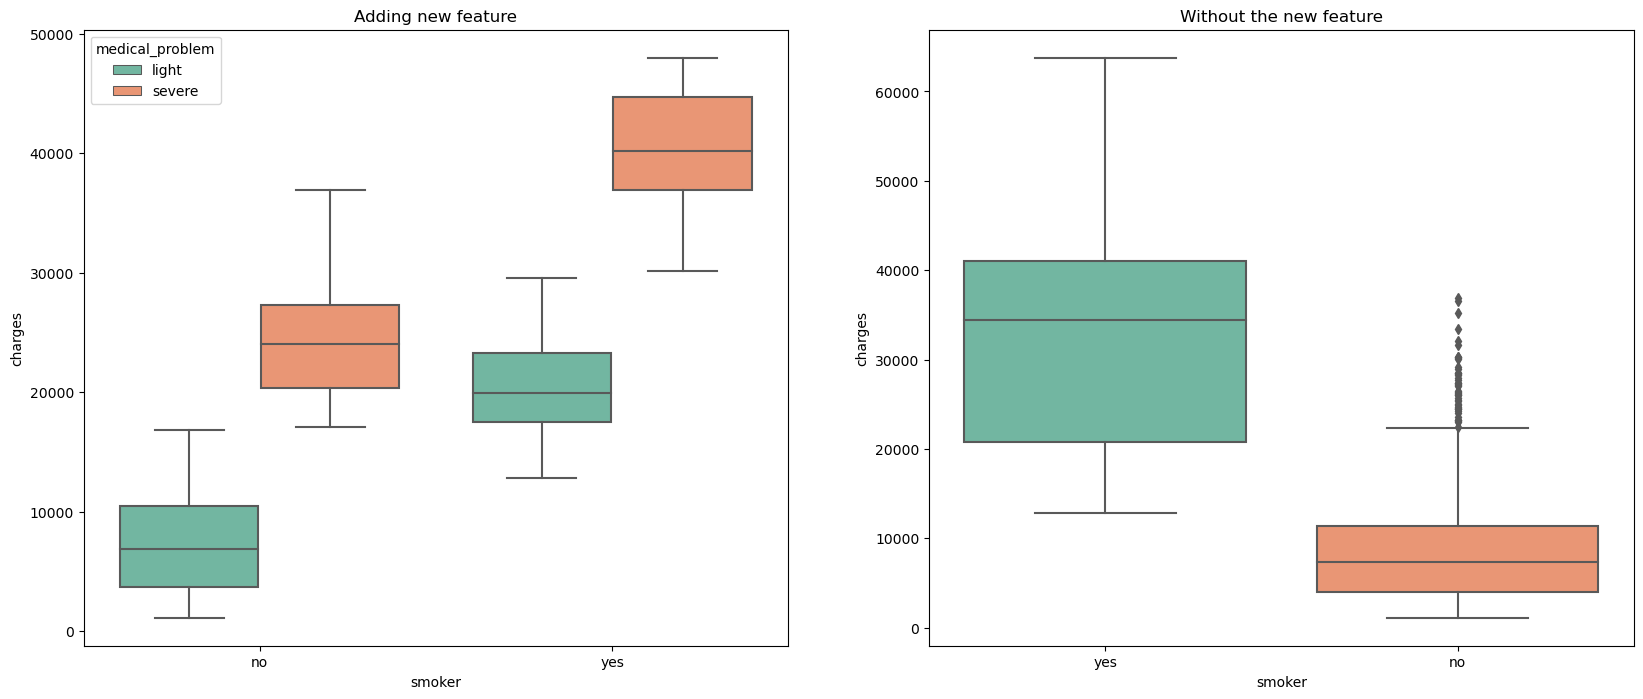

In [31]:
_ = boxplot()

In [32]:
df_clear.isna().sum()

age                0
sex                0
bmi                0
children           0
smoker             0
region             0
charges            0
medical_problem    0
dtype: int64

# Final Model

In [33]:
X = df_clear.drop(columns='charges')
y = df_clear['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
X_train.shape, X_test.shape

((1003, 7), (335, 7))

In [34]:
X_train.head()

,age,sex,bmi,children,smoker,region,medical_problem
103,61,female,29.92,3,yes,southeast,severe
466,60,female,28.70,1,no,southwest,light
388,26,female,22.61,0,no,northwest,light
806,40,female,41.42,1,no,northwest,severe
982,31,male,25.90,3,yes,southwest,light


In [35]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2), ['age','bmi']),
    ('categoric', cat_pipe(encoder='onehot'), ['sex','children','smoker','region', 'medical_problem'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.9693991413123192 0.967425811068947 0.9805384976668903


#### Error

In [36]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

def MSE(model):
    mse_train = round(mean_squared_error(y_train,pred_train), 2)
    mse_test = round(mean_squared_error(y_test,pred_test), 2)
    return mse_train,mse_test

def MAE(model):
    mae_train = round(mean_absolute_error(y_train,pred_train), 2)
    mae_test = round(mean_absolute_error(y_test,pred_test), 2)
    return mae_train,mae_test

mse_train, mse_test = MSE(model)
mae_train, mae_test = MAE(model)

In [37]:
print(f"MAE Train: {mae_train}")
print(f"MAE Test:  {mae_test}")
print('='*25)
print(f"MSE Train: {mse_train}")
print(f"MSE Test:  {mse_test}")
print('='*25)
print(f"RMSE Train: {np.sqrt(mse_train)}")
print(f"RMSE Test:  {np.sqrt(mse_test)}")

MAE Train: 1020.92
MAE Test:  1005.92
MSE Train: 4306746.68
MSE Test:  2841382.33
RMSE Train: 2075.270266736359
RMSE Test:  1685.6400357134378


In [38]:
from jcopml.plot import plot_actual_vs_prediction, plot_roc_curve

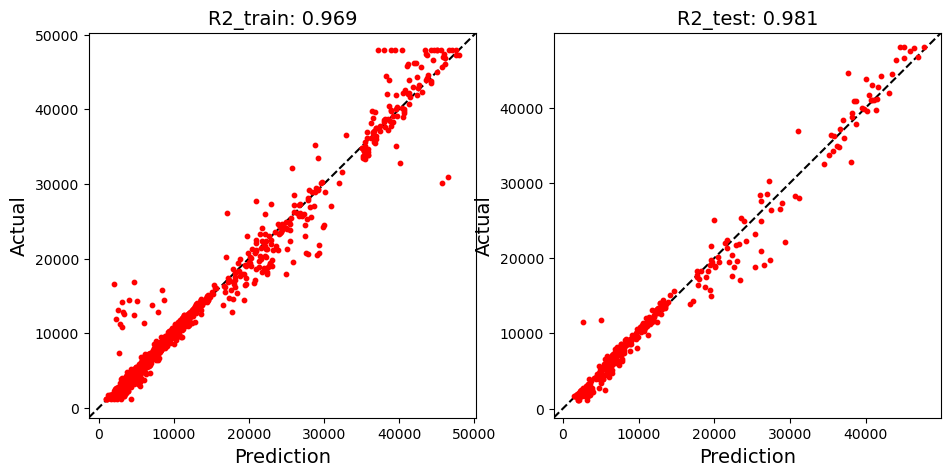

In [39]:
 plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

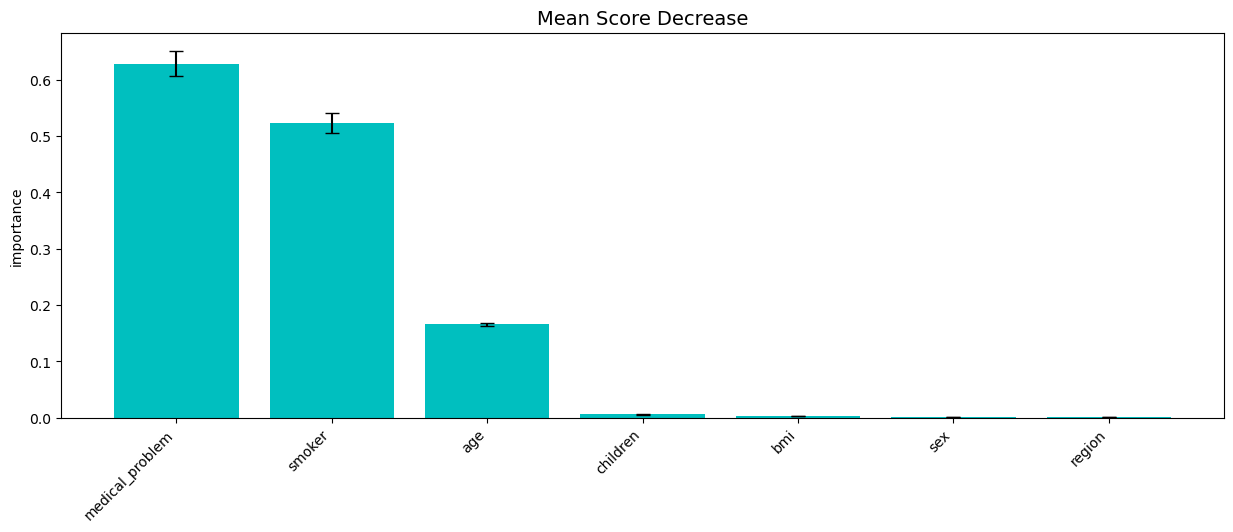

In [40]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

The first three variables have great explanatory power because they describe the quality of a person's health and the more deteriorating the health of the user, the greater the cost of treatment, the other variables at first glance have no weight to make a prediction but they can complement the prediction, resulting in an estimate that is closer to the original value.

## New Prediction

In [41]:
columns = X_train.columns
data = [[22, "male", 18, 0, "no", "northeast", "light"]]
data = pd.DataFrame(data, columns=columns)

model.predict(data)

array([1773.31461882])

## Save
#### json

In [42]:
import json

columns = X_test.columns
columns = {"features":[col for col in columns]}
with open("features.json","w") as F:
    F.write(json.dumps(columns))

#### Model

In [43]:
import joblib

joblib.dump(model, 'final_model.pkl')

['final_model.pkl']

Let's make an app for our insurance price prediction model
___